# Monte Carlo Simulations in Finance Part1

## Reference: 
- Simulating stock prices in Python using Geometric Brownian Motion.https://medium.com/towards-data-science/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18
- Geometric Brownian motion. https://en.wikipedia.org/wiki/Geometric_Brownian_motion
- Monte Carlo Simulation for Black-Scholes Option Pricing.https://medium.com/the-quant-journey/monte-carlo-simulation-for-black-scholes-option-pricing-fd98a669c029
- Options, futures, and other derivatives. Chapter15 Chapter11 Chapter10 
- 买卖权平价关系.https://zh.wikipedia.org/zh-cn/%E4%B9%B0%E5%8D%96%E6%9D%83%E5%B9%B3%E4%BB%B7%E5%85%B3%E7%B3%BB

## Simulating Stock Price Dynamics Using Geometric Brownian Motion



### Monte Carlo Brief Introduction
- A class of algorithms use **repeated random sampling** to solve probabilistic problem.
- To produce a bundle of sample paths(possible outcomes) by spliting time horizon into time steps which is called **discretization**, to approximate continuous time.有点类似于微积分思维
- Main Application
  - derivative pricing: American/European options
  - bonds valuation
  - VaR and Expected shortfall estimation
  - Stress testing in risk management

### Geometric Brownian Motion
- a kind of stochastic process with *stochastic differential equations*(SDE):
  - $dS=μSdt+σSdW_t$
    - $S$: stock prices
    - $μ$: drift coefficient,long term trend in stock price
      - the <u>average return</u> over a given period OR <u>instantaneous</u> expected return
    - $σ$: diffusion coefficient, shorter term fluctuations.
      - how much volatility is in the drift
    - $W_t$: the Brownian Motion path
      - Brownian increments= Standard normal random variable * square root of time increment. Namely, Brownian increments $RV \sim N(0,t)$
      - Brownian path is obtained by taking the `cumulative sum` of the *Brownian increments*.
      - determines how the stock prices fluctuate from <u>beginning time point</u>
      - $W_t=\sum_{i=1}^t b_i$, where $b$ represents brownian increments.
    - $dt$: time increment 
    - $T$: maturity time
- Closed form solution: 
  - $S(t)=S_0e^{(\mu-\frac{1}{2}\sigma^2)t+\sigma W_t}=S_0e^{drift_t+diffusion_t}$
    - $S_0$: S(0), the initial value in process, that is, the initial stock price
    - Expectation: $E(S_t)=S_0e^{\mu t}$
    - Variance: $Var(S_t)=S_0^2 e^{2\mu t}(e^{\sigma^2t}-1)$
- The recursive formula:
  - $S(t_{i+1})=S(t_i)exp(\mu-\frac{1}{2}\sigma^2)(t_{i+1}-t_i)+\sigma \sqrt[2]{t_{i+1}-t_i}*Z_{i+1}$
    - $Z_i$ standard normal random variable
    - $i=0,1,2,...T-1$: time index
- GBM Properties:
  - without taking mean-reversing and time-dependent volatility into consideration
  - only used for stock, but <u>not used for bonds</u> since which displays long term reversion to par value. 

In [1]:
import pandas as pd
import numpy as np
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 55.5 MB/s eta 0:00:00


<ipython-input-1-99da2b670ebf>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#define the parameters for data downloading
stock='MSFT'
SD='2022-08-01'
ED='2023-02-28'

In [3]:
price=yf.download(stock, start=SD, end=ED, progress=False)

Average return: -0.04%


<Axes: title={'center': 'MSFT returns: 2022-08-01 - 2023-02-28'}, xlabel='Date'>

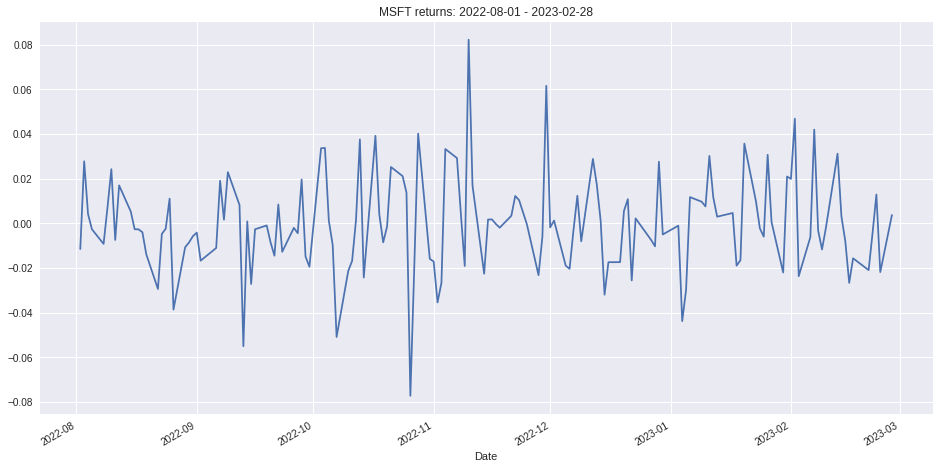

In [4]:
#get the daily returns
adj_close = price['Adj Close'] #rename
returns = adj_close.pct_change().dropna() #calculate the simple returns and removing the missing values
print(f'Average return: {100 * returns.mean():.2f}%') #get the average return
returns.plot(title=f'{stock} returns: {SD} - {ED}',figsize=(16,8)) 

In [5]:
#split data into train and test
train=returns['2022-08-01':'2023-01-31']
test=returns['2023-02-01':'2023-02-28']

In [6]:
#specify the parameters in MC simulation
T=len(test)                            #forecasting time period, with unit of day in this case
N=len(test)                            #Number of time increments in the forecasting horizon
S0=adj_close[train.index[-1]]          #initial price, take the last value from the train dataset.
N_SIM = 100                            #Number of simulated paths
mu=train.mean()                        #drift coefficient
sigma=train.std()                      #diffusion coefficient

In [7]:
#define the simulation function
def simulationGBM(s0, mu, sigma, n_sim, T, N):
  dt=T/N                                                            #time increment
  dW=np.random.normal(scale=np.sqrt(dt), size=(n_sim, N))           #Brownian increment
  W=np.cumsum(dW,axis=1)                                            #Brownian path, running cummulative sum over rows, each row represents one sample path W. While, columns are point of time.
  time_step = np.linspace(dt, T, N)                                 #the time horizon
  time_steps = np.broadcast_to(time_step, (n_sim, N))               #broadcast the array to a new shape
  S_t = s0 * np.exp((mu - 0.5 * sigma** 2) * time_steps+ sigma * W) #construct the close formula with drift and diffusion
  S_t = np.insert(S_t, 0, s0, axis=1)          
  return S_t

In [8]:
#run the function
simulations =simulationGBM(S0, mu, sigma, N_SIM, T, N)

In [9]:
%timeit simulations =simulationGBM(S0, mu, sigma, N_SIM, T, N)

266 µs ± 56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


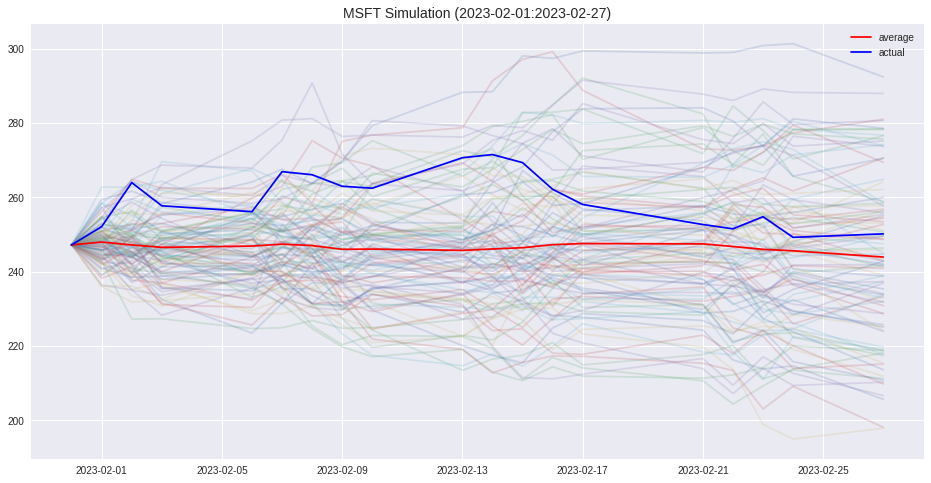

In [10]:
#plot the path
last_trainingdate=train.index[-1].date()
first_testingdate=test.index[0].date()
last_testingdate=test.index[-1].date()

plot_title=(f'{stock} Simulation 'f'({first_testingdate}:{last_testingdate})')
selected_index = adj_close[last_trainingdate:last_testingdate].index
index = [date.date() for date in selected_index]
#convert into dataframe format
simulations_df = pd.DataFrame(np.transpose(simulations), index=index) 
#plotting
ax = simulations_df.plot(alpha=0.2, legend=False,figsize=(16,8))       #choose alpha=.2 to make curves transparent
#add two extra lines
average, = ax.plot(index, simulations_df.mean(axis=1), color='red')
actual, = ax.plot(index, adj_close[last_trainingdate:last_testingdate], color='blue')
ax.set_title(plot_title, fontsize=14)
ax.legend((average, actual), ('average', 'actual'))

#### Alogrithm Simulation: Antithetic Variates
- Reduce variance of estimator by *introducing negative dependence* between pairs of random draws
- Advantage: 
  - reduce the `# of standard normal samples` to be drawn to generate paths
  - reduce sample variance, improving accuracy

In [11]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, antithetic_var=False):
    dt = T/N
    #Brownian
    if antithetic_var:
        dW_antithetic = np.random.normal(scale = np.sqrt(dt), size=(int(n_sims/2), N+1))
        dW = np.concatenate((dW_antithetic, -dW_antithetic), axis=0) #use the negative values
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N + 1))
    #simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, axis=1))  #use the close formula
    S_t[:, 0] = s_0
    return S_t

In [12]:
%timeit gbm_simulations = simulate_gbm(S0, mu, sigma, N_SIM, T, N, antithetic_var=True)

104 µs ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
gbm_simulations = simulate_gbm(S0, mu, sigma, N_SIM, T, N, antithetic_var=True)

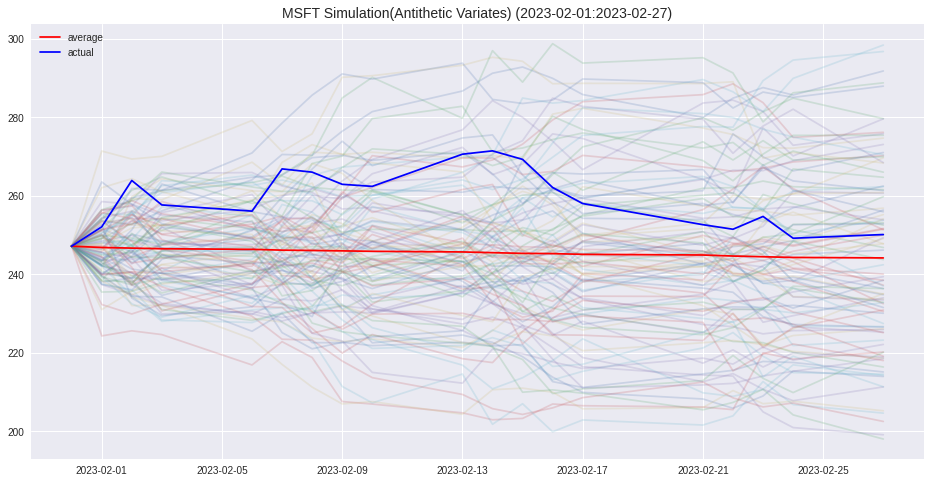

In [14]:
plot_title=(f'{stock} Simulation(Antithetic Variates) 'f'({first_testingdate}:{last_testingdate})')
selected_index = adj_close[last_trainingdate:last_testingdate].index
index = [date.date() for date in selected_index]
#convert into dataframe format
simulations_df1 = pd.DataFrame(np.transpose(gbm_simulations), index=index) 
ax = simulations_df1.plot(alpha=0.2, legend=False,figsize=(16,8))       
average, = ax.plot(index, simulations_df1.mean(axis=1), color='red')
actual, = ax.plot(index, adj_close[last_trainingdate:last_testingdate], color='blue')
ax.set_title(plot_title, fontsize=14)
ax.legend((average, actual), ('average', 'actual'))

## Pricing European Stock Options
- Popular methods of option's valuation
  - Analytic formula
  - Binomial tree approach
  - Finite differences
  - Monte Carlo simulations
- Method: for each simulated path with risk-neutral valuation,we calculate option's *payoff* at maturity,take the *average* of all paths, discount it to *present value*.
- 🌟BSM Pricing Formula:
  - $c=S_0N(d_1)-Ke^{-rT}N(d_2)$
    - Rewrite: $c=e^{-rT}N(d_2)[S_0\frac{e^{-rT}N(d_1)}{N(d_2)}-K]$
  - $p=Ke^{-rT}N(-d_2)-S_0N(-d_1)$
    - $d_1=\frac{ln(S_0/K)+(r+\sigma^2/2)T}{\sigma\sqrt[2]T}$
    - $d_2=\frac{ln(S_0/K)+(r-\sigma^2/2)T}{\sigma\sqrt[2]T}=d_1-\sigma\sqrt[2]T$
    - $N(x)$: cdf for a variable with a standard normal distribution
    - $e^{-rT}$:PV factor
    - $N(d_2)$: probability of exericies in a risk-neutral world
    - $Ke^{-rT}N(d_1)$: expected stock price at time T in risk neutral world
    - $\frac{e^{-rT}N(d_1)}{N(d_2)}$: expected percentage increase in stock price in a risk-neutral world if option is exercised
- Put-Call parity:
  - $c+Ke^{-rT}=p+S_0$
  - The relationship between prices of European put and call options with the same $S_0$ and $T$
  - if the equation not exist-->there exists an arbitrage opportunity.
- Properties:
  - Expected call price: $S_0-Ke^{-rT}$
  - When $S_0$ is larger, a call option has more probability to be exercised, the put option price approxiate to 0.


### Options Related:
- Types of options:
  1. `call options`: give the holder the *right to buy an asset* by a certain date at a certain price.(expiration date/maturity date, exercise/strike price)
    - eg: for European call options, at the maturity date, investors want to meet a **higher** stock price.
      - if stock price($S$)< strike price($K$), the investor can choose not to trade -->he will lose initial investment 
      - if stock price> strike price, the option will be exercised-->the investor will gain[amount*(S-K)], taking initial investment into account, calculate the total <u>net profit or loss</u>. 
  2. `put options`: give the holder the *right to sell an asset* by a certain date at a certain price.
    - eg: for European put options, at the maturity date, investors want to meet a **lower** stock price.
      - if stock price < strike price, the stocks will be sold at strick price, get a gain[amount*(K-S)]-->considering the initial investment, calculate the total net profit or loss.
      - if stock price > strike price, put options expire worthless--> the investor will lose initial investment
  * `American options`: can be exercised *at any time up to* the expiration date(most commonly traded)
  * `European options`: can be exercied *only at* the expiration date. (easier to analyze)
- Option Positions
  - Types:
    1. long position(buy) in call option
      - payoff: $max(S-K,0)$
    2. short position(sell/write:first receive cash, then liability comes) in call option
      - payoff: $-max(S-K,0)=min(K-S,0)$
    3. long position in put option
      - payoff: $max(K-S,0)$
    4. short position in put option
      - payoff: $-max(K-S,0)=min(S-K,0)$
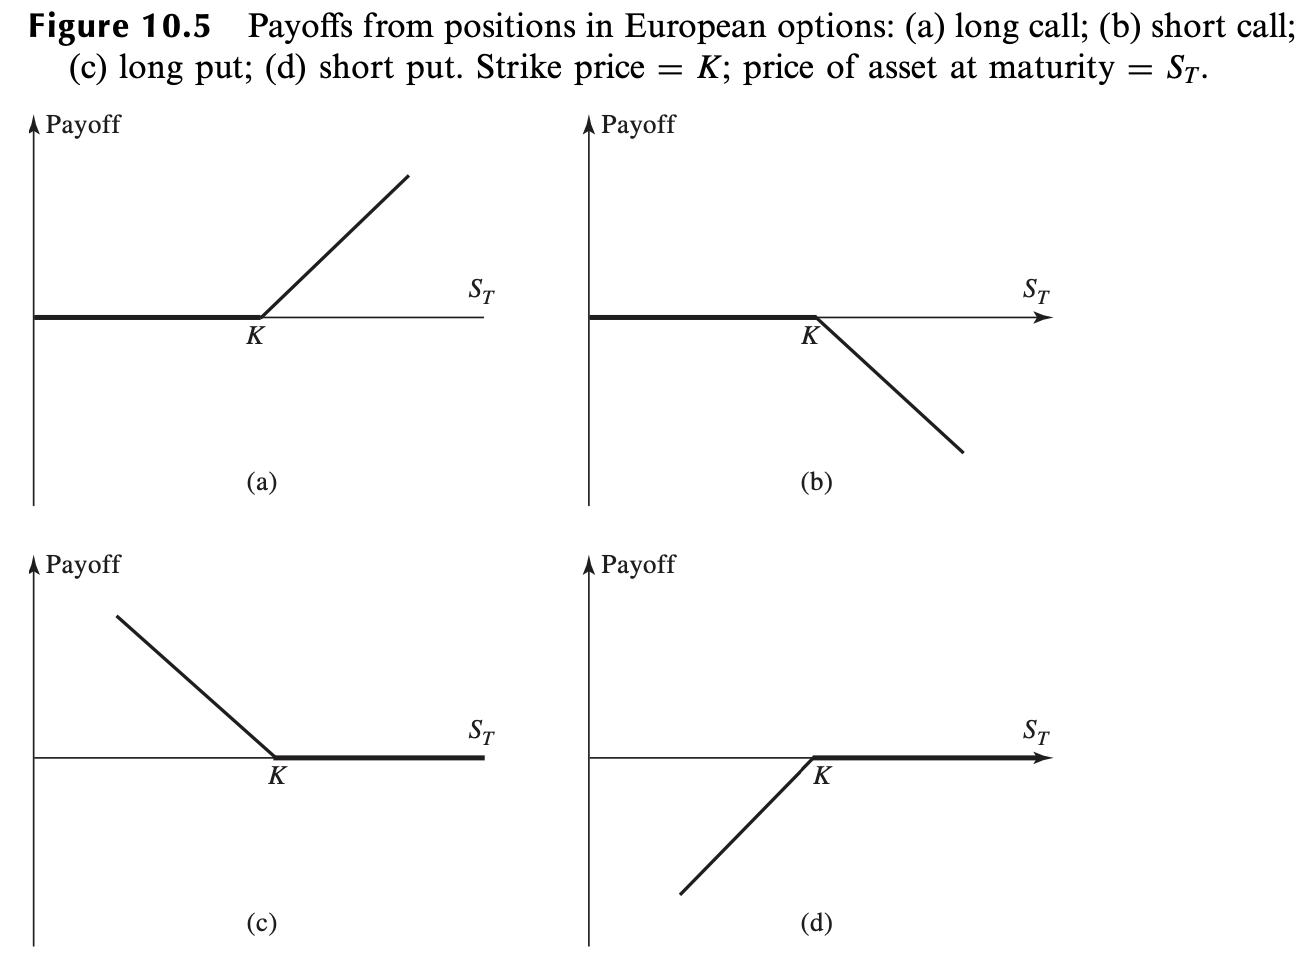
- option class: all options of same types(calls or puts) on a stock.
- option series: all options of a given class with the same expiration date and strike price.


- Underlying assets
  - Stock options
    - trade on exchanges with thousand different stocks given strike price, with the contract size composed of a few 100 shares.
    - Specifications
      - LEAPS: long-term equity anticipation securities, expiration dates up to 39M, in January
      - stirke price:
        - spacing with $0.25, $5, $10 apart
        - stock splits and dividends lead to nonstandard strike price
        - normally set as $75,80,85,90,95
  - Foreign currency options
    - in over-the-counter market or exchange trading with variety of different currencies.
    - one constract: buy/sell 10,000 units of foreign currency for US dollars
  - Index options
    - eg: S&P500 Index(SPX), S&P100 Index(OEX), Nasdaq-100 Index(NDX), DJX
    - most of them are *European options*, except OEX is American.
    - one contract: buy/sell <u>100 * index</u> at stike price
    - settlement in cash
  - Future options
    - normally, future options is traded with American option on contract.
    - life of future options< expiration trading of underlying future contract 

In [16]:
import numpy as np
from scipy.stats import norm

In [24]:
#define the parameters for valuation
S0=100
K=100                            #strike price
r=0.05                           #annual risk free rate
sigma=0.5                        #underlying stock annualized volatility
T=1                              #1 year
N=252                            #trading days, numbers of time increments
dt=T/N                           #time step 
n_sims=10**6                     #numbers of simulation paths
discount_factor=np.exp(-r * T)   #used to calculate the present value of payoff

- in the money: $S > K$
- at the money: $S = K$
- out of the money: $S < K$
- Total value of option= intrinsic value+time value

In [22]:
#define the function using BS analytical method:
def black_scholes_analytical(S0, K, T, r, sigma, type='call'):
  #use the formula
  d1=(np.log(S0/K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
  d2=(np.log(S0/K) + (r - 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
  if type == 'call':
        value = (S0*norm.cdf(d1, 0, 1)-K*np.exp(-r*T)*norm.cdf(d2, 0, 1))
  elif type == 'put':
        value = (K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)-S0*norm.cdf(-d1, 0, 1))
  else:
        raise ValueError('Wrong input for type')
  return value

In [25]:
#valuate the call option using function we defined above
black_scholes_analytical(S0=S0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

- The price of a European call option with the specified parameters is 21.79.

In [27]:
#simulate the stock paths with GBM
gbm_simulation = simulate_gbm(s_0=S0, mu=r, sigma=sigma, n_sims=N_SIM, T=T, N=N)

In [29]:
gbm_simulation

array([[100.        , 101.07522656, 103.12766733, ...,  87.50317836,
         90.04300879,  96.23868906],
       [100.        ,  98.4194937 ,  96.90095094, ..., 106.07974925,
        103.89702132, 102.28464895],
       [100.        ,  95.45960195,  95.5771534 , ...,  53.11304187,
         53.40725934,  51.9672302 ],
       ...,
       [100.        ,  95.99120589,  96.46702881, ...,  65.97805674,
         64.17471403,  63.81979387],
       [100.        ,  98.95169488,  98.91296047, ...,  63.28518306,
         62.73267112,  66.44339265],
       [100.        , 107.36941482, 106.875093  , ...,  96.09837488,
         96.19186444,  99.98429468]])

In [30]:
#calculate the present value of call option premium(S-K) after averaging the simulated stock path
premium = discount_factor * np.average(np.maximum(0, gbm_simulation[:, -1]-K))

In [31]:
premium

18.433184714663117

In [33]:
black_scholes_analytical(S0=S0, K=K, T=T, r=r, sigma=sigma, type='put')

16.915546662938254

#### Another way to calculate premium

In [34]:
#define the premium calculation function
def european_option_simulation(S0, K, T, r, sigma, n_sims, type):
    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)
    
    if type == 'call':
        payoff = np.maximum(0, S_T - K)
    elif type == 'put':
        payoff = np.maximum(0, K - S_T)
    else: 
        raise ValueError('Wrong input for type')
    premium = np.mean(payoff)*np.exp(-r * T) #take average and discounted
    return premium

In [35]:
european_option_simulation(S0, K, T, r, sigma, n_sims, type='put')

16.944043829551017

- In this method, we increase numbers of simulation paths, the accuracy ↑
- This result is similar to the previous one. 